<a href="https://colab.research.google.com/github/ponpatson/Teachable-demo/blob/main/open_closed_eyes_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shehzadhanif_eyes_open_closed_dataset_path = kagglehub.dataset_download('shehzadhanif/eyes-open-closed-dataset')

print('Data source import complete.')


Data source import complete.


In [29]:
import os
import torch
import tqdm
import cv2
import numpy as np
import pandas as pd
from dataclasses import dataclass
import albumentations as augs
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [30]:
@dataclass
class config:
    dataset_directory = shehzadhanif_eyes_open_closed_dataset_path
    best_weights_path = "/kaggle/working/best_model.pth"
    train_directory = os.path.join(dataset_directory, "Eye Dataset", "Train_Data")
    test_directory = os.path.join(dataset_directory, "Eye Dataset", "Test_Data")
    image_height = 128
    image_width = 128
    batch_size = 1028
    num_epochs = 25
    lr = 0.001

## Data Exploration

In [31]:
def generate_annotations(directory : str) -> pd.DataFrame:
    filenames = sorted(os.listdir(directory))
    labels = []

    for filename in filenames:
        labels.append(int(filename.split('_')[4]))

    return pd.DataFrame(dict(
        filename = filenames,
        label = labels
    )).sample(frac=1).reset_index(drop=True)

train_annotations = generate_annotations(config.train_directory)
test_annotations = generate_annotations(config.test_directory)

In [32]:
train_annotations.head()

,filename,label
0,s0001_00726_0_0_0_0_0_01.png,0
1,s0018_02172_0_1_0_0_0_01.png,0
2,s0016_01877_1_0_1_0_0_01.png,1
3,s0015_00663_0_0_0_0_0_01.png,0
4,s0002_00334_0_0_0_0_0_01.png,0


In [33]:
def read_image(filename : str):
    image = cv2.imread(filename)
    return image

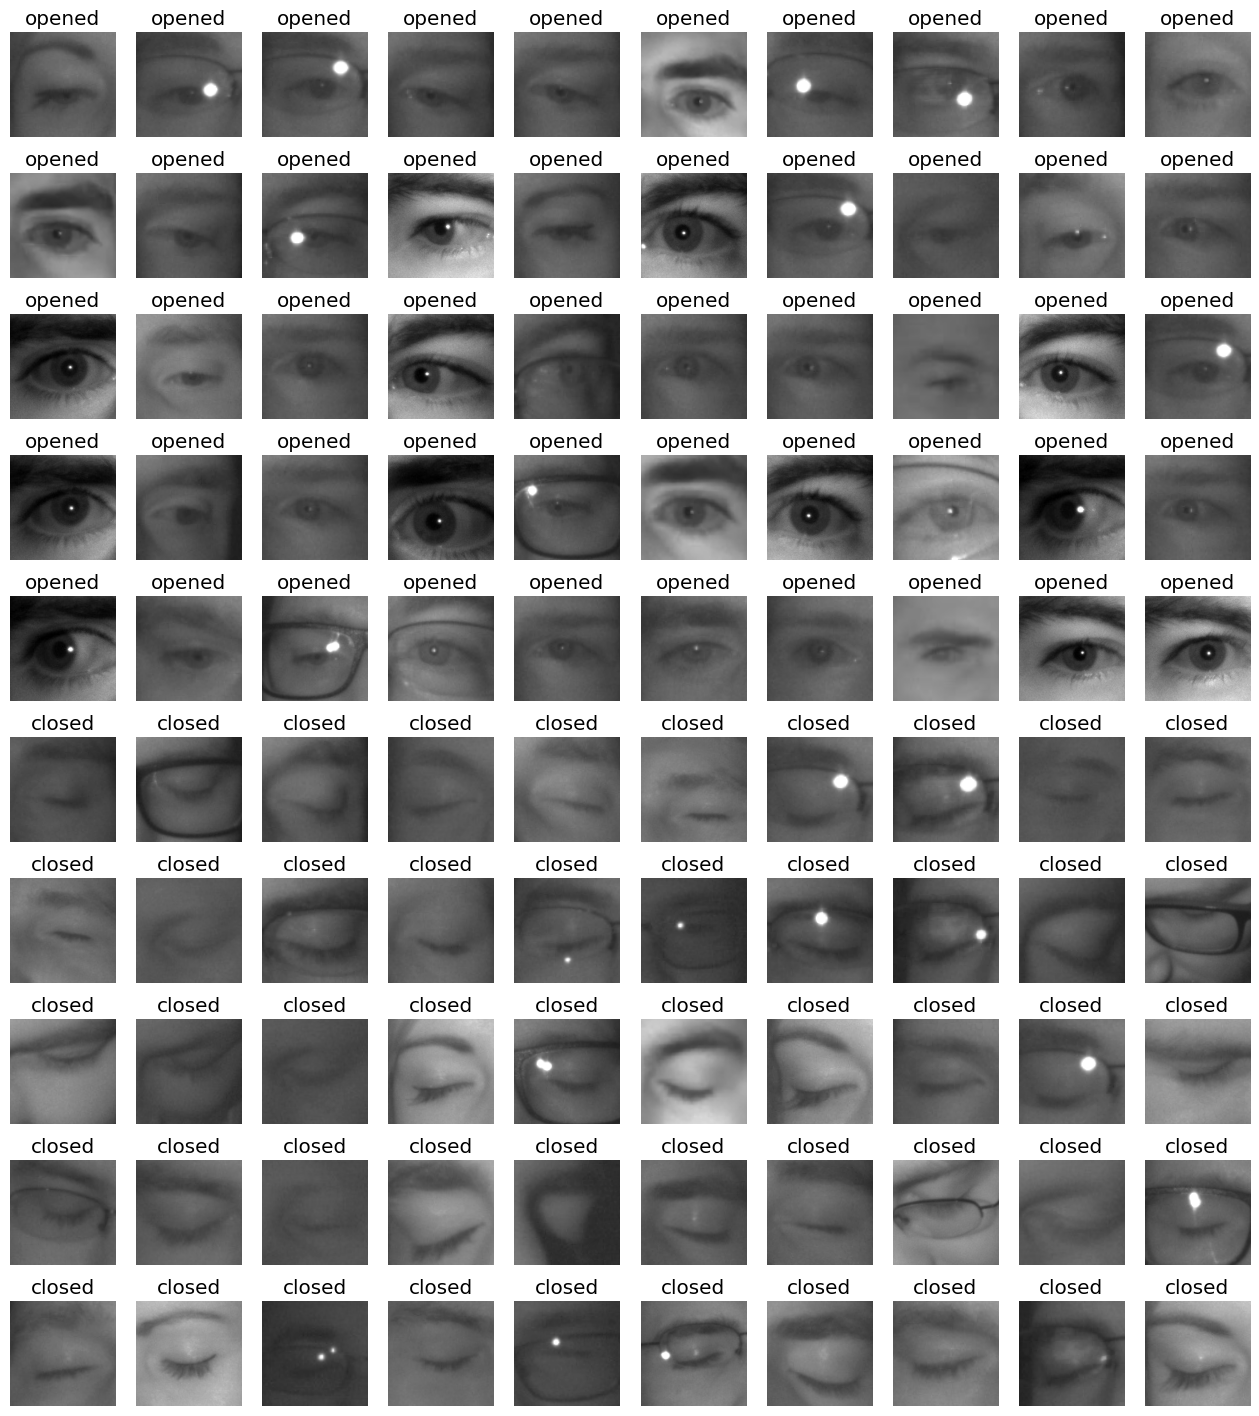

In [34]:
# number of samples for each class
number_of_samples = 50

closed_samples = train_annotations[train_annotations.label == 0].head(number_of_samples)
opened_samples = train_annotations[train_annotations.label == 1].head(number_of_samples)

plt.figure(figsize=(16, 18))

# show "positive" samples
for index, filename in enumerate(opened_samples.filename):
    filename = os.path.join(config.train_directory, filename)
    image = read_image(filename)
    plt.subplot(10, 10, index+1)
    plt.axis('off')
    plt.title('opened')
    plt.imshow(image)

# show "negative" samples
for index, filename in enumerate(closed_samples.filename):
    filename = os.path.join(config.train_directory, filename)
    image = read_image(filename)
    plt.subplot(10, 10, index+number_of_samples+1)
    plt.axis('off')
    plt.title('closed')
    plt.imshow(image)

plt.show()

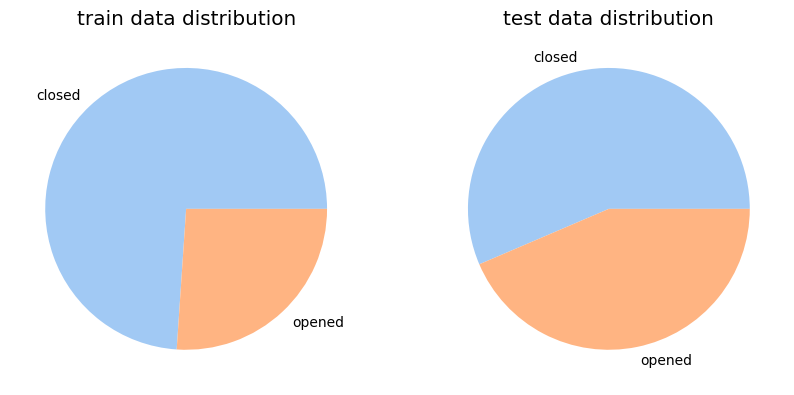

In [35]:
plt.figure(figsize = (10, 16))
plt.subplot(1, 2, 1)
plt.title("train data distribution")
plt.pie(
    train_annotations.label.value_counts(),
    labels = ["closed", 'opened'],
    colors = sns.color_palette('pastel')[0:5],
)

plt.subplot(1, 2, 2)
plt.title("test data distribution")
plt.pie(
    test_annotations.label.value_counts(),
    labels = ["closed", 'opened'],
    colors = sns.color_palette('pastel')[0:5],
)

plt.show()

In [36]:
def equalize_samples(annotations):
    class_count = list(
        train_annotations.label.value_counts()
    )
    opened_eyes_annotations = annotations[annotations.label==1]
    for index in range(abs(class_count[0] - class_count[1])):
        # add one random line with open eyes
        # until class distribution equalizes
        annotations = pd.concat([annotations, opened_eyes_annotations.sample()])
    return annotations

train_annotations = equalize_samples(train_annotations)

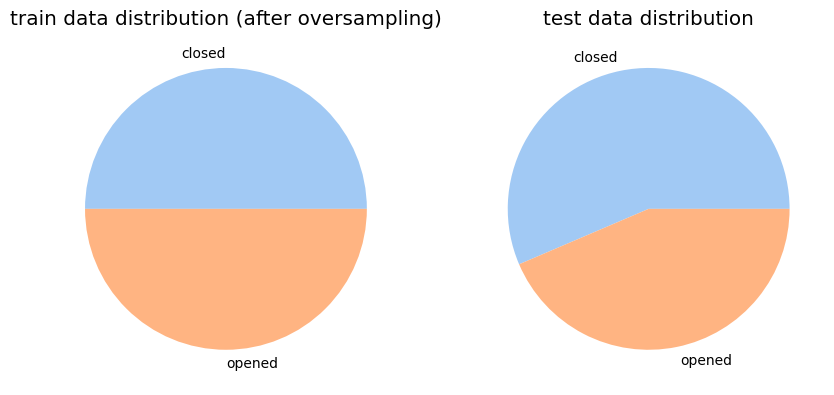

In [37]:
plt.figure(figsize = (10, 16))
plt.subplot(1, 2, 1)
plt.title("train data distribution (after oversampling)")
plt.pie(
    train_annotations.label.value_counts(),
    labels = ["closed", 'opened'],
    colors = sns.color_palette('pastel')[0:5],
)

plt.subplot(1, 2, 2)
plt.title("test data distribution")
plt.pie(
    test_annotations.label.value_counts(),
    labels = ["closed", 'opened'],
    colors = sns.color_palette('pastel')[0:5],
)

plt.show()

## Data Preparation/Augmentation

In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, annotations, apply_augs = True) -> None:
        super(Dataset, self).__init__()
        self.annotations = annotations
        self.augmentations = self.generate_augmentations() if apply_augs else None

    def generate_augmentations(self) -> augs.Compose:
        return augs.Compose([
            # apply random rotation
            augs.Rotate(25),
            # apply contrast augmentations
            augs.OneOf([
                augs.CLAHE(),
                augs.RandomGamma(),
                augs.RandomBrightnessContrast()
            ]),
            # apply blur
            augs.OneOf([
                augs.GaussianBlur(),
                augs.MedianBlur(blur_limit=3),
                augs.MotionBlur()
            ]),
            # apply noise
            augs.OneOf([
                augs.GaussNoise(),
                augs.ISONoise(),
            ])
        ])

    def generate_image(self, filename):
        image = cv2.imread(filename)
        image = cv2.resize(image, (config.image_width, config.image_height))
        if self.augmentations is not None:
            image = self.augmentations(image=image)["image"]
        return image

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        filename, label = list(self.annotations.iloc[index])
        return self.generate_image(filename), label


def add_directory_to_df(annotations, directory):
    train_annotations.filename = train_annotations.filename.apply(
        lambda a: os.path.join(config.train_directory, a)
    )

    return train_annotations

train_dataset = Dataset(
    add_directory_to_df(
        train_annotations,
        config.train_directory
    ),
    apply_augs = True
)

test_dataset = Dataset(
    add_directory_to_df(
        test_annotations,
        config.test_directory
    ),  apply_augs = False
)

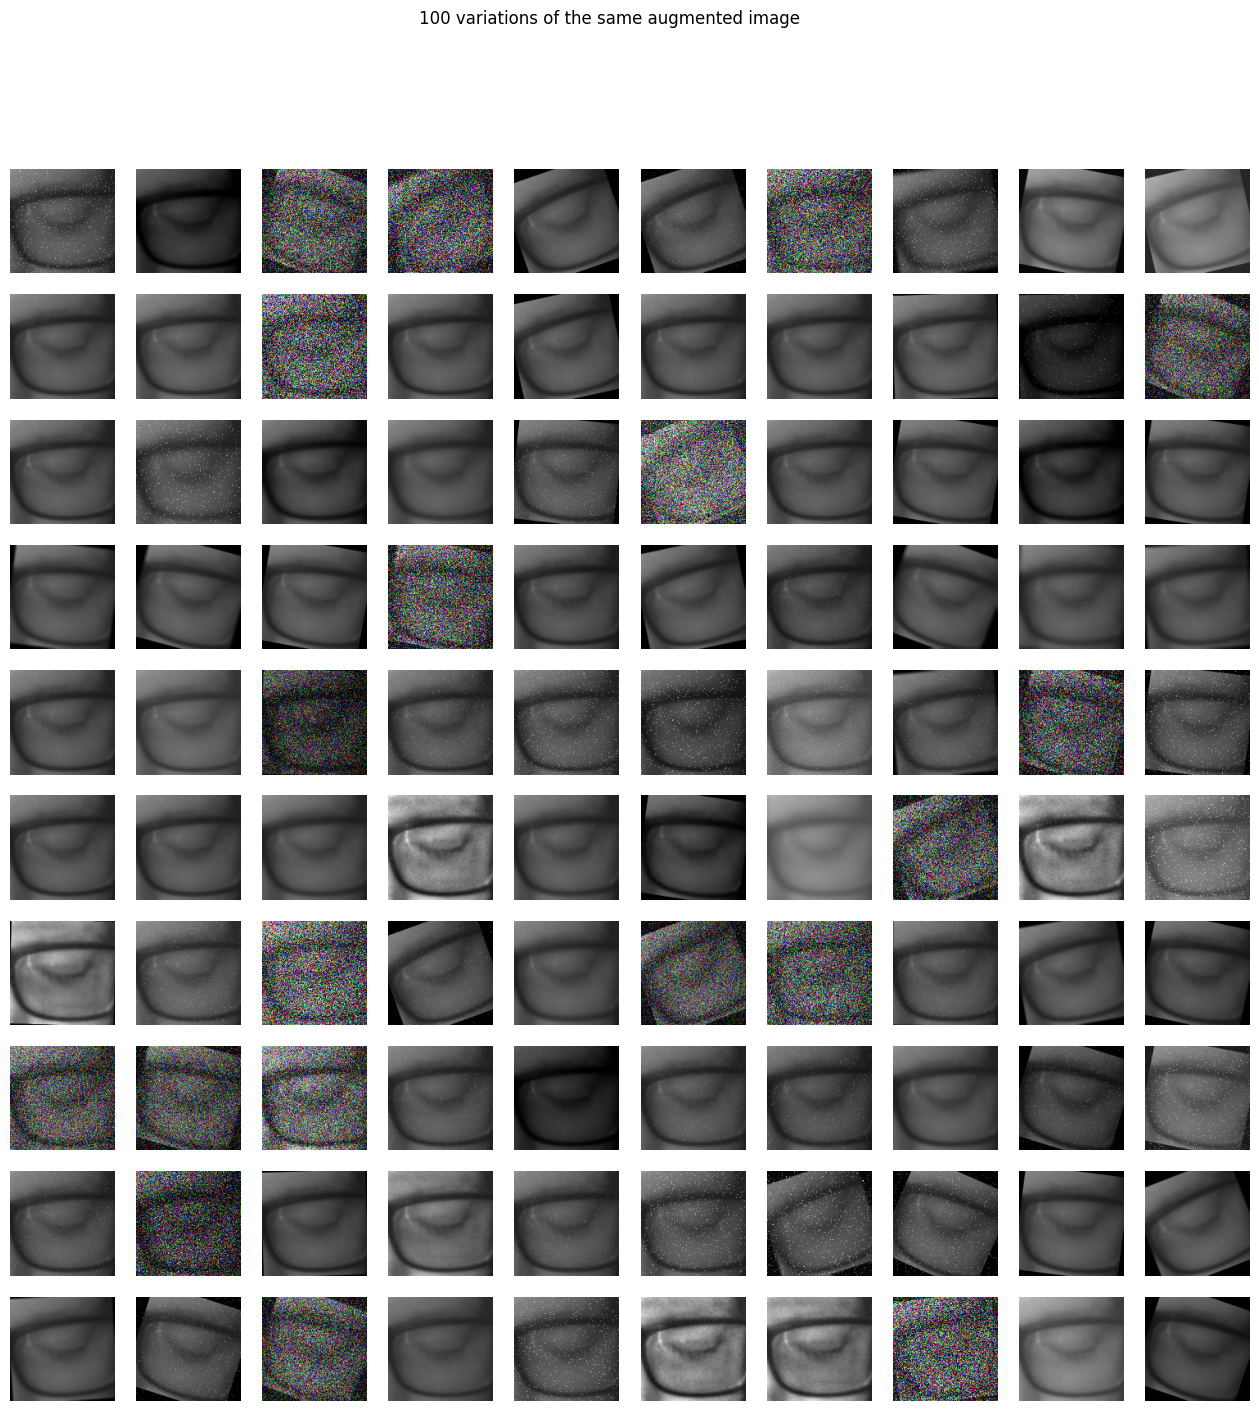

In [39]:
plt.figure(figsize = (16, 16))
n_samples= 100
n_on_side = int(np.ceil(np.sqrt(n_samples)))
plt.suptitle(f'{n_samples} variations of the same augmented image')
for iteration in range(n_samples):
    image, label = train_dataset[1]
    plt.subplot(n_on_side, n_on_side, iteration+1)
    plt.axis("off")
    plt.imshow(image)
plt.show()

## Model

In [40]:
def create_model():
    model = torchvision.models.mobilenet_v3_small(pretrained = True, progress=True)
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=576, out_features=128, bias=True),
        torch.nn.Hardswish(),
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=128, out_features=1, bias=True)
    )
    return model

## Training process

In [41]:
class Trainer:
    def __init__(
        self,
        model,
        train_annotations,
        test_annotations,
        num_epochs,
        batch_size,
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ):

        # hyper-parameters
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = device

        # model
        self.model = model
        self.sigmoid = torch.nn.Sigmoid()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr = config.lr,
        )
        self.criterion = torch.nn.BCELoss()

        # for saving checkpoint
        self.best_accuracy = 0

        # create train dataset/dataloader
        train_dataset = Dataset(
            add_directory_to_df(
                train_annotations,
                config.train_directory
            ),
            apply_augs = True
        )
        self.train_dataLoader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = batch_size,
            collate_fn = self.collate_fn,
        )

        # create test dataset/dataloader
        test_dataset = Dataset(
            add_directory_to_df(
                test_annotations,
                config.test_directory
            ),  apply_augs = False
        )

        self.test_dataLoader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size = config.batch_size,
            collate_fn = self.collate_fn,
        )


    def collate_fn(self, batch):
        images, labels = [], []
        for image, label in batch:
            image = torch.tensor(image / 255)
            image = image.permute((2, 0, 1)).float()
            images.append(image)

            label = torch.tensor([label]).float()
            labels.append(label)

        images = torch.stack(images).to(self.device)
        labels = torch.stack(labels).to(self.device)
        return images, labels

    def measure_accuracy(self, outputs, labels, thrershold=0.6):
        outputs = (outputs>thrershold).float()
        num_correct = (outputs==labels).sum() / len(labels)
        return num_correct

    def train_epoch(self, current_epoch):
        # switch the model to train mode
        self.model.train()

        pbar = tqdm.notebook.tqdm(
            enumerate(self.train_dataLoader),
            total = len(self.train_dataLoader),
            desc = f"Epoch(train) {current_epoch} "
        )

        running_loss = 0
        running_accuracy = 0

        for index, (images, labels) in pbar:
            outputs = self.model(images)
            loss = self.criterion(
                self.sigmoid(outputs),
                labels,
            )

            running_accuracy += self.measure_accuracy(outputs, labels).item()
            running_loss += loss.item()

            pbar.set_postfix(
                dict(
                    accuracy = round(running_accuracy/(index+1), 5),
                    loss = round(running_loss/(index+1), 5)
                )
            )
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


    def test_epoch(self, current_epoch):
        # switch model to evaluation mode
        self.model.eval()

        pbar = tqdm.notebook.tqdm(
            enumerate(self.test_dataLoader),
            total = len(self.test_dataLoader),
            desc = f"Epoch(test) {current_epoch} "
        )

        running_loss = 0
        running_accuracy = 0

        for index, (images, labels) in pbar:
            with torch.no_grad():
                outputs = self.model(images)

            running_loss += self.criterion(
                self.sigmoid(outputs),
                labels,
            ).item()

            running_accuracy += self.measure_accuracy(outputs, labels).item()

            pbar.set_postfix(
                dict(
                    accuracy = round(running_accuracy/(index+1), 5),
                    loss = round(running_loss/(index+1), 5)
                )
            )

        if running_accuracy/index > self.best_accuracy:
            self.best_accuracy = running_accuracy/index
            torch.save(self.model.state_dict(), config.best_weights_path)
            print(f"saved model weights at: {config.best_weights_path}")

    def start(self):
        print(f"Start training using {self.device}")
        self.model.to(self.device)
        for epoch in range(self.num_epochs):
            self.train_epoch(epoch)
            self.test_epoch(epoch)

trainer = Trainer(
    create_model(),
    train_annotations,
    test_annotations,
    config.num_epochs,
    config.batch_size,
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 38.6MB/s]


In [ ]:
trainer.start()

Start training using cpu


Epoch(train) 0 :   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
model = trainer.model
model.eval()

In [ ]:
plt.figure(figsize=(5, 30))
for index in range(10):
    current_image = test_dataset[index][0]
    input_image = torch.tensor([np.array(current_image) / 255]).permute([0, 3, 1, 2]).float().to(trainer.device)
    output = round(trainer.sigmoid(model(input_image)).item(), 5)
    plt.subplot(10, 1, index+1)
    plt.title(f"label: {output}")
    plt.axis("off")
    plt.imshow(current_image)
plt.show()